# Data Prep & EDA 

In [1]:
# 0) Setup & Imports
from pathlib import Path
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Reuse helpers from your uploaded train_model.py for canonical normalization
import importlib.util
spec = importlib.util.spec_from_file_location("train_model", "train_model.py")
train_model = importlib.util.module_from_spec(spec)
spec.loader.exec_module(train_model)

# I/O config
DATA_FILES = ["AB_US_2020.csv", "AB_US_2023.csv"]
OUT_DIR = Path("pointwise_artifacts"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# Artifacts
CLEAN_PATH = OUT_DIR / "cleaned_data.csv"
SAMPLE_PATH = OUT_DIR / "cleaned_sample.csv"
FEATURES_JSON = OUT_DIR / "feature_list.json"
SCHEMA_JSON = OUT_DIR / "final_schema.json"
EDA_JSON = OUT_DIR / "eda_summary.json"
PDF_PATH = OUT_DIR / "eda_report.pdf"

# Convenience aliases
NUMERIC_COLS = train_model.NUMERIC_COLS
CAT_COLS = train_model.CATEGORICAL_COLS


## 1) Data Cleaning

In [2]:
# 1.1) Load & Normalize (canonicalize columns, parse price/percent/bathrooms)
from pathlib import Path

def load_and_normalize(files):
    dfs, maps = [], []
    for f in files:
        p = Path(f)
        if not p.exists():
            print(f"[WARN] Missing: {p}")
            continue
        raw = pd.read_csv(p, low_memory=False)
        norm, fmap = train_model.normalize_df(raw)  # canonical schema + parsing
        dfs.append(norm); maps.append((p.name, fmap))
    if not dfs:
        raise FileNotFoundError("No input CSVs found.")
    return pd.concat(dfs, ignore_index=True), maps

df0, col_maps = load_and_normalize(DATA_FILES)
df0.head()


,city,state,neighbourhood_group,neighbourhood,latitude,longitude,room_type,property_type,accommodates,bedrooms,bathrooms,minimum_nights,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,calculated_host_listings_count,host_response_rate,price
0,Asheville,NaN,NaN,28804,35.65146,-82.62792,Private room,NaN,NaN,NaN,NaN,1,0,138,NaN,1.14,1,NaN,60.0
1,Asheville,NaN,NaN,28801,35.59779,-82.55540,Entire home/apt,NaN,NaN,NaN,NaN,1,288,114,NaN,1.03,11,NaN,470.0
2,Asheville,NaN,NaN,28801,35.60670,-82.55563,Entire home/apt,NaN,NaN,NaN,NaN,30,298,89,NaN,0.81,2,NaN,75.0
3,Asheville,NaN,NaN,28806,35.57864,-82.59578,Entire home/apt,NaN,NaN,NaN,NaN,1,0,267,NaN,2.39,5,NaN,90.0
4,Asheville,NaN,NaN,28801,35.61442,-82.54127,Private room,NaN,NaN,NaN,NaN,30,0,58,NaN,0.52,1,NaN,125.0


In [3]:
# 1.2) Duplicates — drop by id/listing_id if present, else exact duplicate rows
dup_before = len(df0)
if any(c in df0.columns for c in ["id","listing_id","ID"]):
    key = next(c for c in ["id","listing_id","ID"] if c in df0.columns)
    df1 = df0.drop_duplicates(subset=[key])
    dup_key = key
else:
    df1 = df0.drop_duplicates()
    dup_key = None
dup_after = len(df1)
print(f"Duplicates removed: {dup_before - dup_after} (key={dup_key or 'exact-rows'})")
df1.head()


Duplicates removed: 1508 (key=exact-rows)


,city,state,neighbourhood_group,neighbourhood,latitude,longitude,room_type,property_type,accommodates,bedrooms,bathrooms,minimum_nights,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,calculated_host_listings_count,host_response_rate,price
0,Asheville,NaN,NaN,28804,35.65146,-82.62792,Private room,NaN,NaN,NaN,NaN,1,0,138,NaN,1.14,1,NaN,60.0
1,Asheville,NaN,NaN,28801,35.59779,-82.55540,Entire home/apt,NaN,NaN,NaN,NaN,1,288,114,NaN,1.03,11,NaN,470.0
2,Asheville,NaN,NaN,28801,35.60670,-82.55563,Entire home/apt,NaN,NaN,NaN,NaN,30,298,89,NaN,0.81,2,NaN,75.0
3,Asheville,NaN,NaN,28806,35.57864,-82.59578,Entire home/apt,NaN,NaN,NaN,NaN,1,0,267,NaN,2.39,5,NaN,90.0
4,Asheville,NaN,NaN,28801,35.61442,-82.54127,Private room,NaN,NaN,NaN,NaN,30,0,58,NaN,0.52,1,NaN,125.0


In [4]:
# 1.3) Missing values — drop rows missing target; keep others for imputation later
rows_before_price = len(df1)
df2 = df1.dropna(subset=["price"]).copy()
print(f"Dropped rows missing price: {rows_before_price - len(df2)} → {len(df2)} remain")

# Inspect missingness (pre-imputation)
miss_num = df2[NUMERIC_COLS].isna().mean().round(3)
miss_cat = df2[CAT_COLS].isna().mean().round(3)
print("Missing (%) numeric:\n", miss_num.to_dict())
print("Missing (%) categorical:\n", miss_cat.to_dict())

df2.head()


Dropped rows missing price: 0 → 456669 remain
Missing (%) numeric:
 {'accommodates': 1.0, 'bedrooms': 1.0, 'bathrooms': 1.0, 'minimum_nights': 0.0, 'availability_365': 0.0, 'number_of_reviews': 0.0, 'review_scores_rating': 1.0, 'reviews_per_month': 0.211, 'calculated_host_listings_count': 0.0, 'latitude': 0.0, 'longitude': 0.0, 'host_response_rate': 1.0}
Missing (%) categorical:
 {'state': 1.0, 'city': 0.0, 'neighbourhood_group': 0.548, 'neighbourhood': 0.0, 'room_type': 0.0, 'property_type': 1.0}


,city,state,neighbourhood_group,neighbourhood,latitude,longitude,room_type,property_type,accommodates,bedrooms,bathrooms,minimum_nights,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,calculated_host_listings_count,host_response_rate,price
0,Asheville,NaN,NaN,28804,35.65146,-82.62792,Private room,NaN,NaN,NaN,NaN,1,0,138,NaN,1.14,1,NaN,60.0
1,Asheville,NaN,NaN,28801,35.59779,-82.55540,Entire home/apt,NaN,NaN,NaN,NaN,1,288,114,NaN,1.03,11,NaN,470.0
2,Asheville,NaN,NaN,28801,35.60670,-82.55563,Entire home/apt,NaN,NaN,NaN,NaN,30,298,89,NaN,0.81,2,NaN,75.0
3,Asheville,NaN,NaN,28806,35.57864,-82.59578,Entire home/apt,NaN,NaN,NaN,NaN,1,0,267,NaN,2.39,5,NaN,90.0
4,Asheville,NaN,NaN,28801,35.61442,-82.54127,Private room,NaN,NaN,NaN,NaN,30,0,58,NaN,0.52,1,NaN,125.0


In [5]:
# 1.4) Categorical cleanup — strip/standardize labels; rare level grouping preview
def group_rare(series: pd.Series, top_n=20):
    vc = series.value_counts(dropna=False)
    keep = set(vc.head(top_n).index)
    return series.where(series.isin(keep), other="Other")

df2 = df2.copy()
for c in CAT_COLS:
    if c in df2.columns:
        df2[c] = df2[c].astype(str).str.strip().replace({"nan": np.nan, "": np.nan})

# Preview grouping (not applied yet; we’ll apply in Transform step if desired)
cat_preview = {c: df2[c].value_counts().head(10) for c in CAT_COLS if c in df2.columns}
{c: v.to_dict() for c, v in cat_preview.items()}


{'state': {},
 'city': {'New York City': 88603,
  'Los Angeles': 73777,
  'Broward County': 27733,
  'San Diego': 25253,
  'Austin': 24498,
  'Hawaii': 22414,
  'Clark County': 21908,
  'Nashville': 14626,
  'Chicago': 14122,
  'San Francisco': 13937},
 'neighbourhood_group': {'City of Los Angeles': 39599,
  'Manhattan': 37830,
  'Brooklyn': 34493,
  'Other Cities': 27791,
  'Queens': 12649,
  'Maui': 7891,
  'Unincorporated Areas': 6387,
  'Honolulu': 6313,
  'Hawaii': 4963,
  'Kauai': 3247},
 'neighbourhood': {'Unincorporated Areas': 19472,
  'Hollywood': 10380,
  'Fort Lauderdale': 6748,
  'Hennepin': 6466,
  'Bedford-Stuyvesant': 6456,
  'Williamsburg': 6007,
  'San Jose': 5733,
  'Midtown': 4908,
  'Harlem': 4544,
  'East Village': 4266},
 'room_type': {'Entire home/apt': 322525,
  'Private room': 125013,
  'Shared room': 6273,
  'Hotel room': 2858},
 'property_type': {}}

In [6]:
# 1.5) Outliers — robust bounds for price using IQR and 1–99% guards (apply if not too destructive)
outlier_bounds = None
df_clean = df2.copy()
if len(df_clean) >= 500:
    p = df_clean["price"].dropna()
    q1, q3 = p.quantile(0.25), p.quantile(0.75)
    iqr = q3 - q1
    iqr_low, iqr_high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    q01, q99 = p.quantile(0.01), p.quantile(0.99)
    lo = max(10.0, iqr_low, q01)  # sensible minimum
    hi = min(iqr_high, q99)
    pre = len(df_clean)
    filt = df_clean["price"].between(lo, hi)
    if filt.mean() > 0.5:
        df_clean = df_clean.loc[filt].copy()
        outlier_bounds = (float(lo), float(hi))
        print(f"Outlier filter kept {len(df_clean)}/{pre} rows; price in [{lo:.2f}, {hi:.2f}]")
    else:
        print("Skipped outlier filter (too destructive).")
else:
    print("Dataset < 500 rows — skipping outlier clipping.")

# Light sanity fixes
if "bedrooms" in df_clean.columns:
    df_clean.loc[df_clean["bedrooms"] < 0, "bedrooms"] = np.nan
if "accommodates" in df_clean.columns:
    df_clean.loc[df_clean["accommodates"] < 1, "accommodates"] = 1

df_clean.shape


Outlier filter kept 412409/456669 rows; price in [29.00, 449.50]


(412409, 19)

## 2) Data Transformation

In [7]:
# 2.1) Type conversions (ensure numeric dtypes where expected)
for c in NUMERIC_COLS:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")
df_clean[NUMERIC_COLS].dtypes


accommodates                      float64
bedrooms                          float64
bathrooms                         float64
minimum_nights                      int64
availability_365                    int64
number_of_reviews                   int64
review_scores_rating              float64
reviews_per_month                 float64
calculated_host_listings_count      int64
latitude                          float64
longitude                         float64
host_response_rate                float64
dtype: object

In [8]:
# 2.2) Date/Time parsing (if host_since / calendar_last_scraped exist)
def parse_optional_dates(df):
    out = {}
    for cand in ["host_since", "Host Since"]:
        if cand in df.columns:
            s = pd.to_datetime(df[cand], errors="coerce")
            df["host_since_year"] = s.dt.year
            df["host_since_month"] = s.dt.month
            out["host_since"] = cand
            break
    for cand in ["calendar_last_scraped", "Calendar Last Scraped"]:
        if cand in df.columns:
            s = pd.to_datetime(df[cand], errors="coerce")
            df["scraped_year"] = s.dt.year
            df["scraped_month"] = s.dt.month
            out["calendar_last_scraped"] = cand
            break
    return df, out

df_clean, parsed_dates_map = parse_optional_dates(df_clean)
parsed_dates_map


{}

In [9]:
# 2.3) Encoding & scaling strategy (documented, not executed here):
# - Numeric: Standardization with StandardScaler (applied inside modeling pipeline)
# - Categorical: OneHotEncoder(handle_unknown='ignore', min_frequency=20)
# If you want a quick preview encoding (not for training), uncomment below:

# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
#
# numeric_pipe = Pipeline([("scaler", StandardScaler())])
# cat_pipe = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=20))])
# pre = ColumnTransformer([("num", numeric_pipe, NUMERIC_COLS), ("cat", cat_pipe, CAT_COLS)])
# _X = df_clean[NUMERIC_COLS + CAT_COLS].copy()
# X_preview = pre.fit_transform(_X)
# X_preview


In [10]:
# 2.4) Optional: apply rare-level grouping to reduce cardinality for EDA or lightweight models
for c in CAT_COLS:
    if c in df_clean.columns:
        df_clean[c] = (df_clean[c].astype(object))  # ensure object dtype
        vc = df_clean[c].value_counts(dropna=False)
        keep = set(vc.head(20).index)
        df_clean[c] = df_clean[c].where(df_clean[c].isin(keep), other="Other")
{c: df_clean[c].nunique(dropna=False) for c in CAT_COLS if c in df_clean.columns}


{'state': 1,
 'city': 21,
 'neighbourhood_group': 21,
 'neighbourhood': 21,
 'room_type': 4,
 'property_type': 1}

## 3) Feature Engineering

In [11]:
# 3.1) Transformations (log/ratios); Interactions/density proxies
df_fe = df_clean.copy()
if "price" in df_fe.columns:
    df_fe["log_price"] = np.log1p(df_fe["price"])
if all(c in df_fe.columns for c in ["price","bedrooms"]):
    df_fe["price_per_bedroom"] = df_fe.apply(
        lambda r: r["price"]/r["bedrooms"] if pd.notna(r["price"]) and pd.notna(r["bedrooms"]) and r["bedrooms"]>0 else np.nan,
        axis=1
    )
if all(c in df_fe.columns for c in ["accommodates","bedrooms"]):
    df_fe["guests_per_bedroom"] = df_fe.apply(
        lambda r: r["accommodates"]/r["bedrooms"] if pd.notna(r["accommodates"]) and pd.notna(r["bedrooms"]) and r["bedrooms"]>0 else np.nan,
        axis=1
    )
engineered_cols = [c for c in ["log_price","price_per_bedroom","guests_per_bedroom","host_since_year","host_since_month","scraped_year","scraped_month"] if c in df_fe.columns]
engineered_cols


['log_price', 'price_per_bedroom', 'guests_per_bedroom']

In [12]:
# 3.2) Aggregations (example): group price stats by room_type
agg_room = None
if "room_type" in df_fe.columns:
    agg_room = df_fe.groupby("room_type")["price"].agg(["count","mean","median","std"]).sort_values("mean", ascending=False)
agg_room


,count,mean,median,std
room_type,,,,
Hotel room,2208,180.827899,161.0,94.567718
Entire home/apt,286719,174.932809,150.0,89.191240
Private room,119001,89.259998,70.0,62.986272
Shared room,4481,64.507922,45.0,54.998429


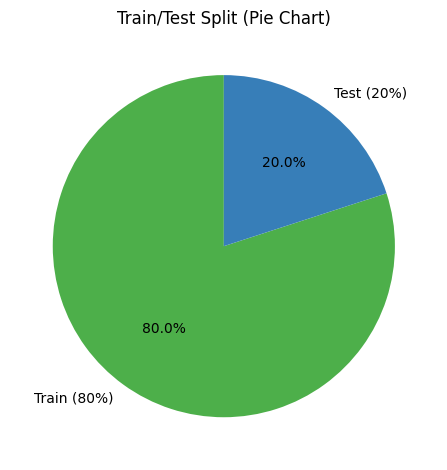

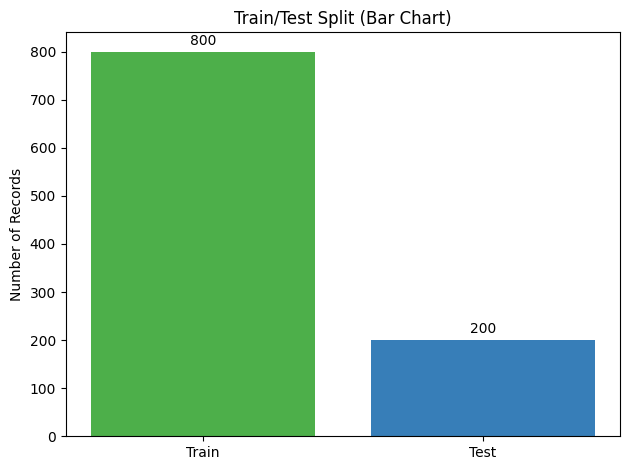

In [25]:
import matplotlib.pyplot as plt

# 🔹 Replace these with your actual split counts
train_size = 800  
test_size = 200  

# -------------------- Pie Chart --------------------
sizes = [train_size, test_size]
labels = ["Train (80%)", "Test (20%)"]
colors = ["#4daf4a", "#377eb8"]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, colors=colors)
ax.set_title("Train/Test Split (Pie Chart)")
plt.tight_layout()
plt.show()

# -------------------- Bar Chart --------------------
fig, ax = plt.subplots()
ax.bar(["Train", "Test"], [train_size, test_size], color=colors)
ax.set_ylabel("Number of Records")
ax.set_title("Train/Test Split (Bar Chart)")
for i, v in enumerate([train_size, test_size]):
    ax.text(i, v + (max([train_size, test_size]) * 0.01), str(v), 
            ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.show()


## 4) Data Integration

In [13]:
# 4.1) Multi-source vertical concat already done in load; show schema alignment mapping example
schema_alignment_example = col_maps[0][1]  # mapping dict from first file processed
list(schema_alignment_example.items())[:12]


[('city', 'city'),
 ('state', None),
 ('neighbourhood_group', 'neighbourhood_group'),
 ('neighbourhood', 'neighbourhood'),
 ('latitude', 'latitude'),
 ('longitude', 'longitude'),
 ('room_type', 'room_type'),
 ('property_type', None),
 ('accommodates', None),
 ('bedrooms', None),
 ('bathrooms', None),
 ('minimum_nights', 'minimum_nights')]

## 5) Data Splitting & Balancing

In [14]:
# 5.1) Train/Test split (regression → no class imbalance handling needed)
from sklearn.model_selection import train_test_split

X = df_fe[NUMERIC_COLS + CAT_COLS].copy()
y = df_fe["price"].astype(float).values

n = len(df_fe)
test_size = 0.2 if n >= 5 else 0.4 if n >= 3 else 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

split_info = {
    "rows_total_after_cleaning": int(n),
    "train_rows": int(len(X_train)),
    "test_rows": int(len(X_test)),
    "test_size": float(test_size),
    "imbalance_note": "Continuous target; SMOTE/undersampling not applicable."
}
split_info


{'rows_total_after_cleaning': 412409,
 'train_rows': 329927,
 'test_rows': 82482,
 'test_size': 0.2,
 'imbalance_note': 'Continuous target; SMOTE/undersampling not applicable.'}

## 6) Exploratory Data Analysis (EDA)

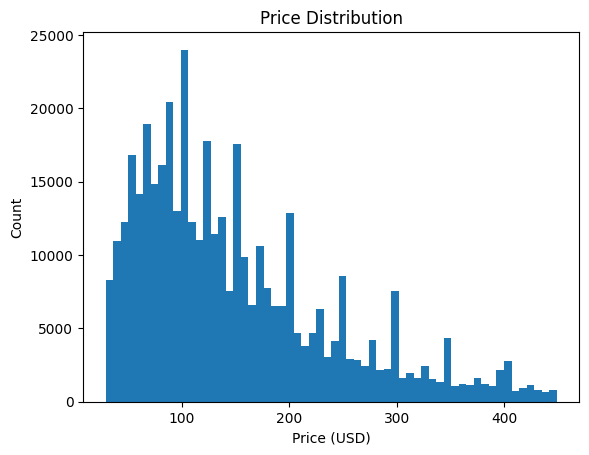

In [15]:
# 6.1) Univariate: hist of price
plt.figure()
plt.hist(df_fe["price"].dropna(), bins=60)
plt.title("Price Distribution"); plt.xlabel("Price (USD)"); plt.ylabel("Count")
plt.show()


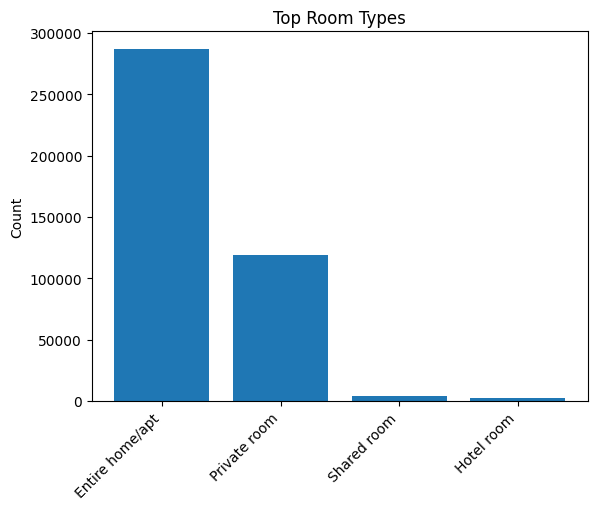

In [16]:
# 6.2) Univariate: top room types
plt.figure()
rt_counts = df_fe["room_type"].value_counts().head(10)
plt.bar(rt_counts.index.astype(str), rt_counts.values)
plt.title("Top Room Types"); plt.xticks(rotation=45, ha="right"); plt.ylabel("Count")
plt.show()


C:\Users\GANDLA PRAVALLIKA\AppData\Local\Temp\ipykernel_17172\1038970785.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=top_rooms, showfliers=False)


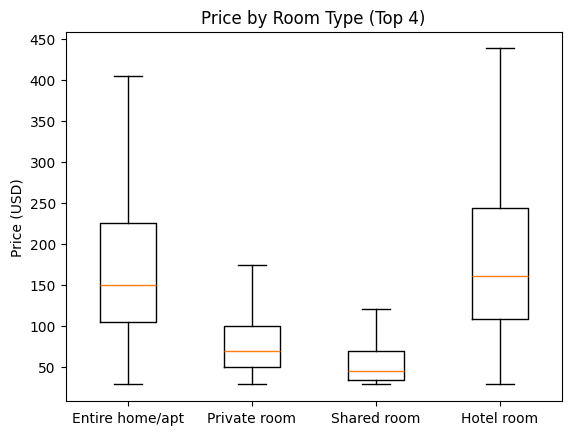

In [17]:
# 6.3) Bivariate: boxplot price by top 4 room types
plt.figure()
top_rooms = df_fe["room_type"].value_counts().head(4).index.tolist()
groups = [df_fe.loc[df_fe["room_type"]==r, "price"].dropna() for r in top_rooms]
plt.boxplot(groups, labels=top_rooms, showfliers=False)
plt.title("Price by Room Type (Top 4)"); plt.ylabel("Price (USD)")
plt.show()


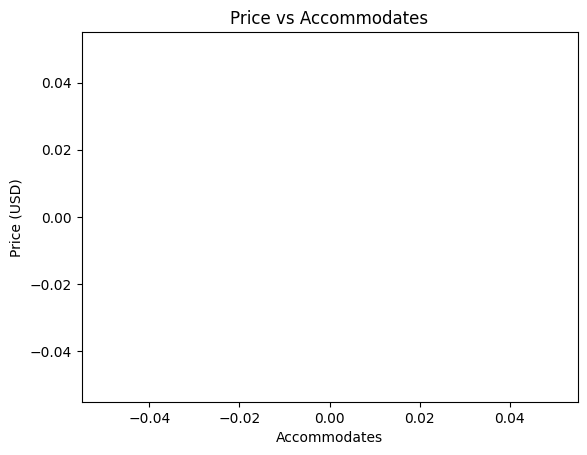

In [18]:
# 6.4) Bivariate: scatter price vs accommodates
plt.figure()
plt.scatter(df_fe["accommodates"], df_fe["price"], s=8)
plt.title("Price vs Accommodates"); plt.xlabel("Accommodates"); plt.ylabel("Price (USD)")
plt.show()


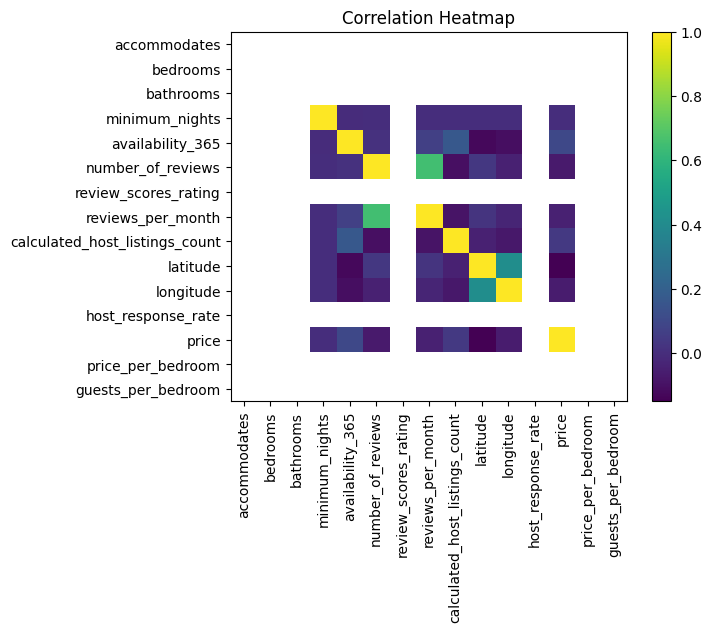

In [19]:
# 6.5) Correlation heatmap (numeric + engineered)
num_cols_for_corr = [c for c in NUMERIC_COLS if c != "price"] + ["price"] + [c for c in engineered_cols if c != "log_price"]
corr = df_fe[num_cols_for_corr].corr(numeric_only=True)
plt.figure()
im = plt.imshow(corr, aspect="auto")
plt.title("Correlation Heatmap")
plt.colorbar(im)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()


In [20]:
# 6.6) Key insights (auto-summarize a few quick stats)
insights = {
    "price_iqr": df_fe["price"].quantile([0.25, 0.5, 0.75]).to_dict() if "price" in df_fe.columns else None,
    "accommodates_vs_price_corr": float(df_fe[["accommodates","price"]].corr(numeric_only=True).iloc[0,1]) if set(["accommodates","price"]).issubset(df_fe.columns) else None,
    "top_room_type_by_median_price": df_fe.groupby("room_type")["price"].median().sort_values(ascending=False).head(5).to_dict() if "room_type" in df_fe.columns else None,
}
insights


{'price_iqr': {0.25: 80.0, 0.5: 125.0, 0.75: 199.0},
 'accommodates_vs_price_corr': nan,
 'top_room_type_by_median_price': {'Hotel room': 161.0,
  'Entire home/apt': 150.0,
  'Private room': 70.0,
  'Shared room': 45.0}}

## 7) Deliverables

In [21]:
# 7.1) Save cleaned dataset & sample
df_fe.to_csv(CLEAN_PATH, index=False)
df_fe.sample(min(100, len(df_fe))).to_csv(SAMPLE_PATH, index=False)
{"cleaned_path": str(CLEAN_PATH), "sample_path": str(SAMPLE_PATH)}


{'cleaned_path': 'pointwise_artifacts\\cleaned_data.csv',
 'sample_path': 'pointwise_artifacts\\cleaned_sample.csv'}

In [22]:
# 7.2) Feature list + definitions
feature_defs = {
    "numeric_features": NUMERIC_COLS,
    "categorical_features": CAT_COLS,
    "engineered_features": [c for c in ["log_price","price_per_bedroom","guests_per_bedroom","host_since_year","host_since_month","scraped_year","scraped_month"] if c in df_fe.columns],
    "definitions": {
        "price": "Nightly price in USD (target)",
        "log_price": "log(1 + price) for skew reduction",
        "price_per_bedroom": "Price divided by bedrooms",
        "guests_per_bedroom": "Accommodates divided by bedrooms",
        "host_since_year/month": "Parsed from host_since, if present",
        "scraped_year/month": "Parsed from calendar_last_scraped, if present"
    }
}
with open(FEATURES_JSON, "w") as f: json.dump(feature_defs, f, indent=2)
str(FEATURES_JSON)


'pointwise_artifacts\\feature_list.json'

In [23]:
# 7.3) Final schema & metadata
schema_meta = {
    "columns": list(df_fe.columns),
    "numeric_cols": NUMERIC_COLS,
    "categorical_cols": CAT_COLS,
    "engineered_cols": feature_defs["engineered_features"],
    "duplicate_drop_key": (None if 'dup_key' not in globals() else dup_key),
    "column_mappings_example": col_maps[0][1]
}
with open(SCHEMA_JSON, "w") as f: json.dump(schema_meta, f, indent=2, default=str)
str(SCHEMA_JSON)


'pointwise_artifacts\\final_schema.json'

In [24]:
# 7.4) Optional: compact 5-page PDF (cover + 4 figures)
with PdfPages(PDF_PATH) as pdf:
    # Cover text
    fig = plt.figure(); plt.axis("off")
    lines = [
        "Data Prep & EDA — Summary",
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
        f"Rows after cleaning: {len(df_fe):,}",
        f"Duplicates removed: {dup_before - dup_after:,} (key={dup_key or 'exact-rows'})",
        f"Outlier bounds (price): {outlier_bounds if outlier_bounds else 'N/A'}",
        "Transform: Standardize numeric; One-Hot for categorical (min_frequency=20) in pipeline",
        f"Engineered: {', '.join(feature_defs['engineered_features']) or 'None'}",
        f"Split: train/test = {1 - (len(y_test)/len(df_fe)):.0%}/{len(y_test)/len(df_fe):.0%}",
    ]
    plt.text(0.05, 0.95, "\n".join(lines), va="top", fontsize=10)
    pdf.savefig(fig); plt.close(fig)

    # Figures: price hist, room types, boxplot, scatter
    plt.figure(); plt.hist(df_fe["price"].dropna(), bins=60); plt.title("Price Distribution"); plt.xlabel("Price"); plt.ylabel("Count"); pdf.savefig(); plt.close()
    plt.figure(); rt = df_fe["room_type"].value_counts().head(10); plt.bar(rt.index.astype(str), rt.values); plt.title("Top Room Types"); plt.xticks(rotation=45, ha="right"); plt.ylabel("Count"); pdf.savefig(); plt.close()
    plt.figure(); top_rooms = df_fe["room_type"].value_counts().head(4).index.tolist(); groups = [df_fe.loc[df_fe['room_type']==r, 'price'].dropna() for r in top_rooms]; plt.boxplot(groups, labels=top_rooms, showfliers=False); plt.title("Price by Room Type (Top 4)"); plt.ylabel("Price"); pdf.savefig(); plt.close()
    plt.figure(); plt.scatter(df_fe["accommodates"], df_fe["price"], s=8); plt.title("Price vs Accommodates"); plt.xlabel("Accommodates"); plt.ylabel("Price"); pdf.savefig(); plt.close()

str(PDF_PATH)


C:\Users\GANDLA PRAVALLIKA\AppData\Local\Temp\ipykernel_17172\2426511266.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); top_rooms = df_fe["room_type"].value_counts().head(4).index.tolist(); groups = [df_fe.loc[df_fe['room_type']==r, 'price'].dropna() for r in top_rooms]; plt.boxplot(groups, labels=top_rooms, showfliers=False); plt.title("Price by Room Type (Top 4)"); plt.ylabel("Price"); pdf.savefig(); plt.close()


'pointwise_artifacts\\eda_report.pdf'

> **Note:** Scaling and One-Hot encoding are typically applied inside the modeling pipeline (e.g., `ColumnTransformer` + `Pipeline`). In this notebook we preview data prep and EDA, and export cleaned artifacts for modeling.

In [1]:
import pandas as pd

# Load cleaned dataset (update the path if needed)
df_clean = pd.read_csv("cleaned_data.csv")

# Show first 10 rows
print("📋 First 10 rows of the cleaned dataset:")
print(df_clean.head(10).to_string(index=False))


📋 First 10 rows of the cleaned dataset:
 city  state neighbourhood_group neighbourhood  latitude  longitude       room_type  property_type  accommodates  bedrooms  bathrooms  minimum_nights  availability_365  number_of_reviews  review_scores_rating  reviews_per_month  calculated_host_listings_count  host_response_rate  price
Other    NaN City of Los Angeles         Other  35.65146  -82.62792    Private room            NaN           NaN       NaN        NaN               1                 0                138                   NaN               1.14                               1                 NaN   60.0
Other    NaN City of Los Angeles         Other  35.60670  -82.55563 Entire home/apt            NaN           NaN       NaN        NaN              30               298                 89                   NaN               0.81                               2                 NaN   75.0
Other    NaN City of Los Angeles         Other  35.57864  -82.59578 Entire home/apt            NaN 